# Pr-Intern Tests

In [1]:
from huggingface_hub import login
import matplotlib.pyplot as plt
import torch

from reasoning_experiments.test_utils import *
login(
    token="..."
)

## Experiment Configurations
Define different experimental setups with various model configurations

In [2]:
experiments={
    'exp0':{'language':False,'vision':False,'expert':False,'lora':False,'RAG':False,'path':"meta-llama/Llama-3.2-11B-Vision-Instruct"},
    'exp2':{'language':False,'vision':False,'expert':True,'lora':False,'RAG':False,'path':'/home/cm2161/rds/hpc-work/ex.2/checkpoint-279'},
    # 'exp2+RAG':{'language':False,'vision':False,'expert':True,'lora':False,'RAG':True,'path':'/home/cm2161/rds/hpc-work/ex.2/checkpoint-279'},
    # 'exp2+codebook':{'language':False,'vision':False,'expert':True,'lora':False,'codebook':True,'path':'/home/cm2161/rds/hpc-work/ex.2/checkpoint-279'},
}

## Model / datasets loader

### Model

In [3]:
def load_and_prepare_model(experiment):
    
    model, processor, vision_expert = load_model_and_processor(
        experiment,
    )

    model.eval()
    return model, processor, vision_expert

### Naive control dataset

In [3]:
import random

with open("reasoning_experiments/vanilla_control/prompt.txt", "r") as file:
    prompt_template = file.read()

tests = []
for _ in range(100):
    E = random.randint(30, 300) 
    F = random.randint(E-30, E+30)
    ANSWER = (100 / E) * F

    tests.append({"context":prompt_template.format(E=E, F=F), "answer":ANSWER})

print(tests[0])

naive_control_dataset = batchify(tests, batch_size=8)


FileNotFoundError: [Errno 2] No such file or directory: 'reasoning_experiments/vanilla_control/prompt.txt'

### Domain questions dataset

In [7]:
import json

# Load domain questions from the JSON file
with open("reasoning_experiments/domain_knowledge/3d_printing_questions.json", "r") as file:
    domain_questions = json.load(file)["questions"]

# Prepare the dataset for evaluation
domain_qs = []
for question in domain_questions:
    domain_qs.append({"question": question})  # Placeholder for answers

print(domain_qs[0])

domain_questions_dataset = batchify(domain_qs, batch_size=8)


{'question': 'How do thermal gradients during FDM printing affect residual stress in polymer parts?'}


### Emerging capabilities dataset

In [4]:
import json

with open("reasoning_experiments/emerging_control/prompt.txt", "r") as file:
    prompt_template = file.read()

with open("reasoning_experiments/emerging_control/system_command.txt", "r") as file:
    system_message = file.read()

# Load case tests from the JSON file
with open("reasoning_experiments/emerging_control/case_tests.json", "r") as file:
    case_tests = json.load(file)

playbook = {    "M104 - Set Hotend Temperature": {
    "function": "M104",
    "description": "Set a new target hot end temperature.",
    "hyperlink": "https://marlinfw.org/docs/gcode/M104.html"
    },

    "M106 - Set Fan Speed": {
    "function": "M106",
    "description": "Turn on fan and set speed",
    "hyperlink": "https://marlinfw.org/docs/gcode/M106.html"
    },

    "M220 - Set Feed rate": {
    "function": "M220",
    "description": "Set the feed rate for the extruder.",
    "hyperlink": "https://marlinfw.org/docs/gcode/M220.html"
    },

    "M221 - Set Extrusion Flow Rate": {
    "function": "M221",
    "description": "Set the extrusion flow rate for the extruder.",
    "hyperlink": "https://marlinfw.org/docs/gcode/M221.html"
    }
}

def get_entry_by_gcode(gcode_command):
    for key, entry in playbook.items():
        if entry['function'] == gcode_command:
            return entry["hyperlink"]
    return None 

def format_scenario(scenario):
    scenario_info = f"""Given Information:
    estimated_flowrate = {scenario['Given Information']['estimated_flowrate']}
    firmware_flowrate = {scenario['Given Information']['firmware_flowrate']}
    material = {scenario['Given Information']['material']}
    current_temperature = {scenario['Given Information']['current_temperature']}
    feed_rate = {scenario['Given Information']['feed_rate']}"""

    prompt = prompt_template.replace("{system}", scenario_info)
    return prompt

scenarios = []
for scenario in case_tests:
    scenario = format_scenario(scenario)
    scenarios.append({"question":scenario})

case_control_dataset = batchify(scenarios, batch_size=1)
print(case_control_dataset[0][0])

{'question': 'Given Information:\n    estimated_flowrate = 85%\n    firmware_flowrate = 100%\n    material = ABS\n    current_temperature = 220°C\n    feed_rate = 1200 mm/s\n\nAnalyse the given information and select the most relevant adjustment.\nPay attention to the validity of your statements!\nWhile changing the extrusion flow rate may seem the best option, it is not always the best option.\n    Consider physics, material properties, the current temperature and other things you know about additive manufacturing.\nSuggest a single G-code command for the most effective parameter adjustment, if an adjustment is needed.\n\n**Output the gcode command in the gcode tag in this format: ```gcode <command>```**\n    No other information should be within the gcode tag. Do not change lines either.\n    If a command is not needed, just say ```gcode no_command```.\n    If a command is needed, provide the G-code command within the ```gcode <command>``` tags.\n'}


In [5]:
import json
import requests

from bs4 import BeautifulSoup

def fetch_gcode_details(hyperlink):
    response = requests.get(hyperlink)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        details = soup.select_one('body > div.container.detail > div > div.col-lg-9.col-md-8.main')
        return details.text if details else "No details found"
    else:
        return f"Error fetching details: {response.status_code}"

# Load the G-code playbook
with open('/home/cm2161/Documents/llama-manufacturing/pr-intern/reasoning_experiments/emerging_control/gcode_playbook.json') as f:
    gcode_playbook = json.load(f)

## Answer Generation

### Test Naive Control, Llama, Ours

In [10]:
# from tqdm import tqdm

# experiment_results = {}

# for key, value in experiments.items():
#     print(f"Validating: {key}")

#     # Load and prepare model components
#     model, processor, vision_expert = load_and_prepare_model(value)

#     # Test 1: Naive-control dataset evaluation
#     experiment_answers = []
#     experiment_answers_original = []
#     for batch in tqdm(naive_control_dataset, desc="Processing domain control batches"):
#         with torch.no_grad():
#             # Prepare batch
#             batch_collated = val_collate_fn_text(
#                 batch, 
#                 processor
#             ).to(model.device)

#             # Generate outputs
#             outputs = model.generate(
#                 **batch_collated,
#                 max_new_tokens=1024,
#                 temperature=0.2
#             )

#             # Process results
#             decoded_outputs = map(processor.decode, outputs)
#             answers = answer_extractor(decoded_outputs)
#             answers = [round(float(answer.split('<M221 S')[1].split('>')[0]), 2) for answer in answers]
#             original_answers = [round(float(item['answer']), 2) for item in batch]

#             experiment_answers.extend(answers)
#             experiment_answers_original.extend(original_answers)

#             # Save vision results
#             results_df = pd.DataFrame({
#                 'answers': experiment_answers,
#                 'answers_original': experiment_answers_original,
#             })
#             results_df.to_csv(f'reasoning_experiments/naive_control_experiment_results_{key}.csv',
#                             index=True,
#                             index_label='control_id')



### Test domain expertise, Llama, Ours, Ours+RAG

In [11]:
# from tqdm import tqdm


# for key, value in experiments.items():

#     results = []

#     print(f"Validating: {key}")

#     # Load and prepare model components
#     model, processor, vision_expert = load_and_prepare_model(value)

#     # Test 2: Domain-specific QA evaluation
#     for batch in tqdm(domain_questions_dataset, desc="Processing domain questions batches"):
#         with torch.no_grad():
#             # Prepare batch
#             batch_collated = val_collate_fn(
#                 batch, 
#                 processor,
#                 RAG = True if value['RAG'] else False
#                 ).to(model.device)

#             # Generate outputs
#             outputs = model.generate(
#                 **batch_collated,
#                 max_new_tokens=1024,
#                 temperature=0.2
#             )
            
#             decoded_outputs = map(processor.decode, outputs)
#             answers = answer_extractor(decoded_outputs)

#             for example, answer in zip(batch, answers):
#                 question = example['question']
#                 results.append({
#                     "questions": question,
#                     "answer": answer
#                 })

#     # Write the results to a JSON file
#     with open(f'reasoning_experiments/domain_expertise_experiment_results_{key}.json', "w") as file:
#         json.dump(results, file, indent=4)

### Test emerging capabilities, Llama, Ours, Ours+Codebook

In [5]:
from tqdm import tqdm

for key, value in experiments.items():
    
    results = []
    print(f"Validating: {key}")

    # Load and prepare model components
    model, processor, vision_expert = load_and_prepare_model(value)

    # Test 3: Emerging capabilities evaluation
    for batch in tqdm(case_control_dataset, desc="Processing emerging capabilities batches"):

        with open("reasoning_experiments/emerging_control/system_command.txt", "r") as file:
            system_message = file.read()

        # print("Given information:", batch[0]['question'])

        for step in [0]:
            
            if step == 1:

                ### RAG
                embedding = generate_RAG_embedding(answers[0])
                if embedding is not None:
                    similarities = []
                    for fact in processed_facts:
                        embedding_array = np.array(embedding)  # Convert to NumPy array
                        embedding_reshaped = embedding_array.reshape(1, -1)  # Reshape to 2D
                        similarity = cosine_similarity(embedding_reshaped, np.array(fact['embedding']).reshape(1, -1))
                        similarities.append(similarity)

                # Keep N most relevant facts
                N = 5  # Set the number of relevant facts to keep
                top_indices = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)[:N]
                relevant_facts = [processed_facts[i] for i in top_indices]
                relevant_facts_string = "\n| ".join([fact['original_fact'] for fact in relevant_facts])
                system_message += f"\n\nMore relevant information: {relevant_facts_string}"

                ### Codebook
                try:                
                    gcode_command = answers[0].split('gcode')[1].split('```')[0]
                    gcode_command = gcode_command.strip().split(" ")[0]
                    gcode_info = get_entry_by_gcode(gcode_command)
                    details= fetch_gcode_details(gcode_info)
                    system_message += f"\n\nMore relevant information: {details}"
                except:
                    system_message+="It is likely that the G-code command is not needed."

            with torch.no_grad():
                # Prepare batch
                batch_collated = val_collate_fn(
                    batch, 
                    processor,
                    system_message=system_message
                    ).to(model.device)
    
                # Generate outputs
                outputs = model.generate(
                    **batch_collated,
                    max_new_tokens=200,
                    temperature=0.1
                )
                decoded_outputs = map(processor.decode, outputs)
                answers = answer_extractor(decoded_outputs)

                try:
                    gcode_commands = answers.split('```gcode')[1].split('```')[0]
                    print(gcode_commands)
                except:
                    gcode_command = None

        for example, answer in zip(batch, answers):
            question = example['question']
            results.append({
                "questions": question,
                "command": gcode_command,
                "answer": answer
            })

    # Write the results to a JSON file
    with open(f'reasoning_experiments/emerging_control_experiment_results_{key}', "w") as file:
        json.dump(results, file, indent=4)

Validating: exp0


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Processing emerging capabilities batches:  20%|█████████                                    | 10/50 [01:16<04:52,  7.32s/it]

## Evaluation

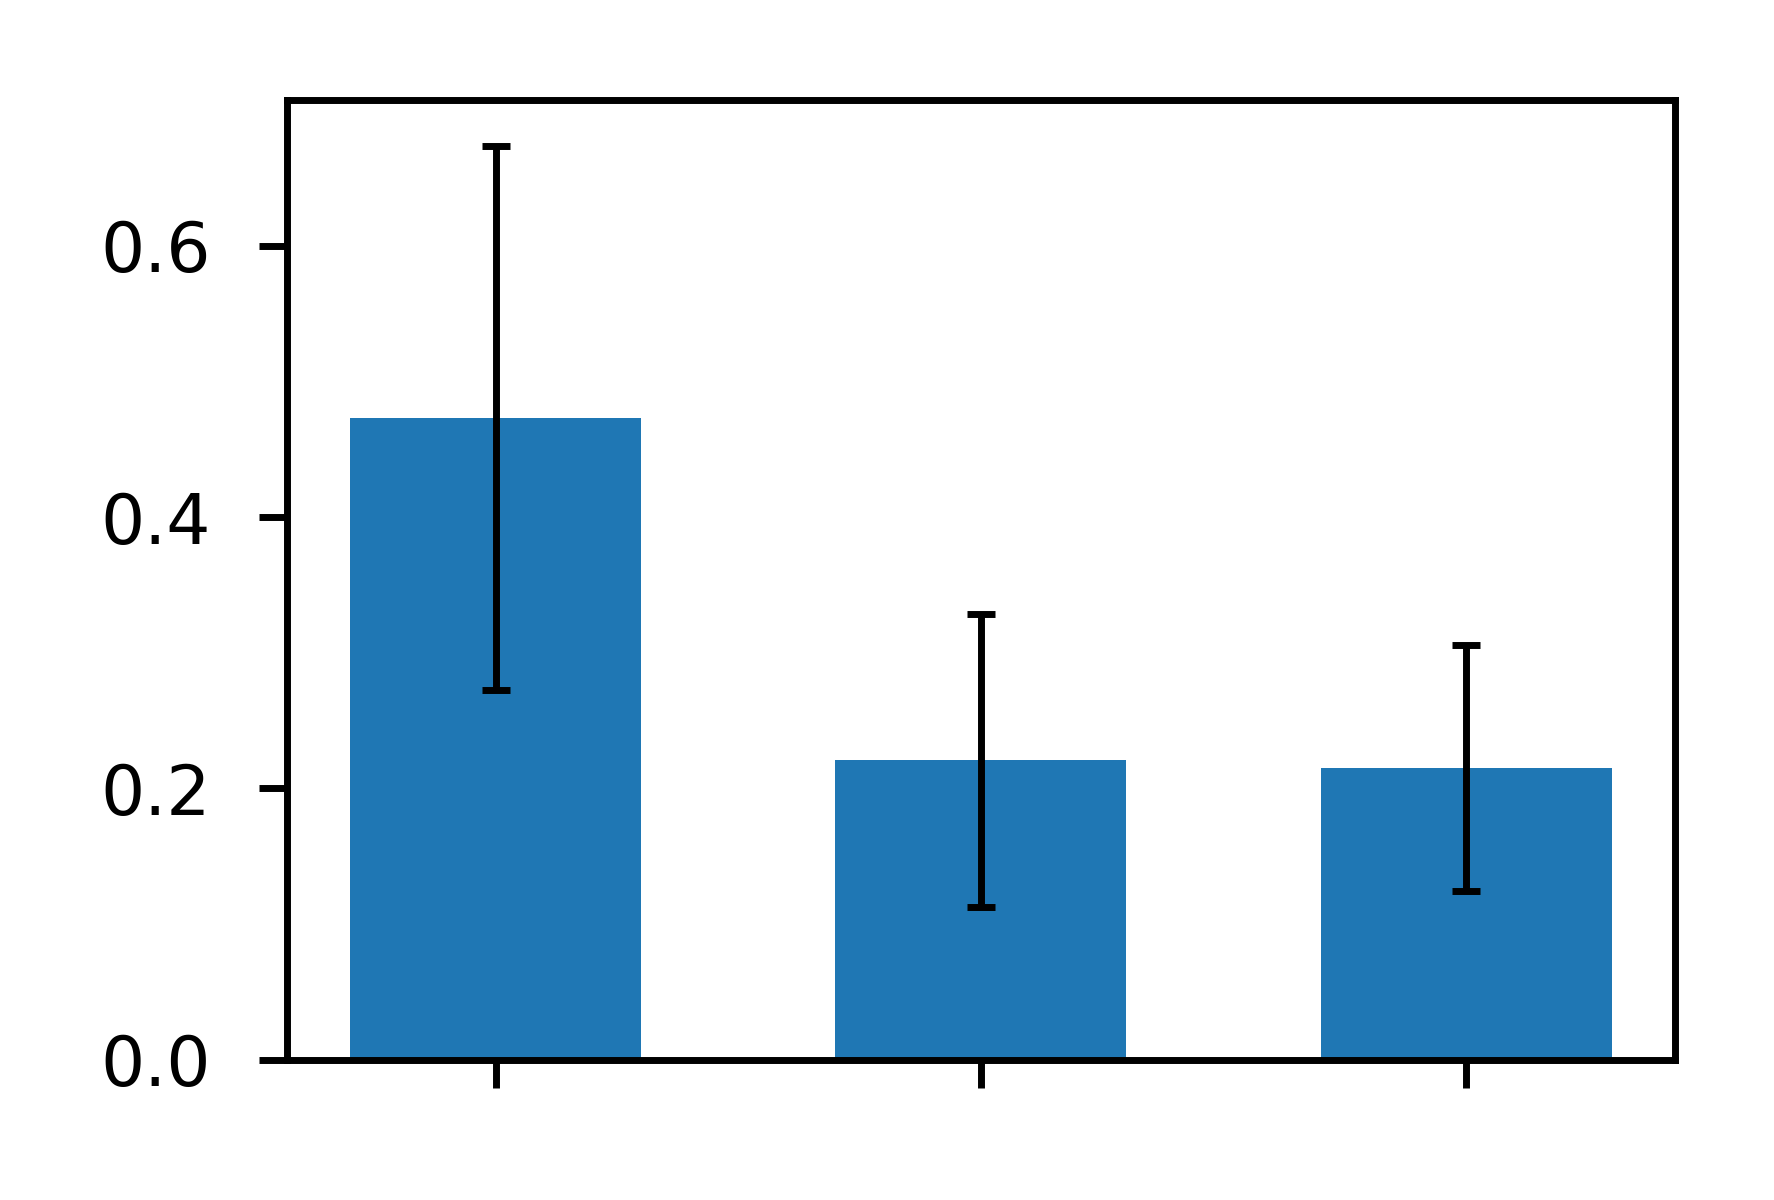

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a single figure for all bar charts
fig, ax = plt.subplots(figsize=(1.5748, 1), dpi=1000)

# Store errors for all experiments
all_errors = []
all_std_errors = []  # To store standard errors
labels = []

for key in [ "gpt4o-mini", "exp0", "exp2",]:
    # Load results
    results_df = pd.read_csv(f'/home/cm2161/Documents/llama-manufacturing/pr-intern/reasoning_experiments/vanilla_control/naive_control_experiment_results_{key}.csv')
    errors = np.abs(results_df['answers'] - results_df['answers_original'])
    all_errors.append(errors.mean())  # Use mean error for bar height
    all_std_errors.append(errors.std()*0.5)  # Use std error for error bars
    labels.append(f"ex.{key[-1]}")

# Create bar chart with error bars
ax.bar(
    labels, 
    all_errors, 
    yerr=all_std_errors,  # Add standard error bars
    capsize=1, 
    width=0.6, 
    linewidth=0.5,              # Line thickness for bars
    error_kw={'elinewidth': 0.5, 'capthick': 0.5},  # Error bar style
)

ax = plt.gca()
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(True)

# Set x-ticks and labels
ax.tick_params(axis='x', bottom=True, labelbottom=False)  # Remove x-ticks and labels
ax.tick_params(axis='both', labelsize=5, width=0.5,  length=2)  # Tick line thickness

# Adjust border thickness
tick_lines = ['top', 'bottom', 'left', 'right']
for spine in tick_lines:
    ax.spines[spine].set_linewidth(0.5)

# Remove any padding
plt.tight_layout(pad=0)
plt.show()


In [ ]:
# Store accuracies and std for all experiments
all_accuracies = []
all_stds = []
labels = []

def bootstrap_accuracy(y_true, y_pred, n_iterations=1000):
    accuracies = []
    n_samples = len(y_true)
    
    for _ in range(n_iterations):
        # Random sampling with replacement
        indices = np.random.randint(0, n_samples, n_samples)
        boot_true = y_true.iloc[indices]
        boot_pred = y_pred.iloc[indices]
        
        # Calculate accuracy for this bootstrap sample
        accuracy = (boot_true == boot_pred).mean() * 100
        accuracies.append(accuracy)
    
    return np.mean(accuracies), np.std(accuracies)

for key in experiments.keys():
    # Load results
    results_df = pd.read_csv(f'/home/cm2161/Documents/llama-manufacturing/pr-intern/experiments/caxton/caxton_experiment_results_{key}.csv')
    
    if 'y_class' in results_df.columns and 'y_class_hat' in results_df.columns:
        # Calculate accuracy and std using bootstrapping
        mean_acc, std_acc = bootstrap_accuracy(
            results_df['y_class'], 
            results_df['y_class_hat']
        )
        all_accuracies.append(mean_acc)
        all_stds.append(std_acc)
        labels.append(f"ex.{key[-1]}")

# Create figure with broken axis
mm_to_inches = 0.0393701
fig_size_inches = 33 * mm_to_inches

fig, (ax1, ax2) = plt.subplots(1, 2, 
                              figsize=(fig_size_inches, fig_size_inches), 
                              dpi=1200,
                              gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.05})

# Plot in both axes with error bars
for ax in [ax1, ax2]:
    ax.barh(labels, all_accuracies, 
            height=0.5,
            xerr=all_stds,
            color='lightgrey',
            edgecolor='black',
            linewidth=0.5,
            error_kw={'ecolor': 'black', 
                     'capsize': 2, 
                     'capthick': 0.5, 
                     'elinewidth': 0.5})
    
    # Style plot
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.invert_yaxis()

# Add white spine between broken axes
ax1.spines['right'].set_visible(True)
ax1.spines['right'].set_color('white')

# Set different limits for each axis
ax1.set_xlim(0, 40)  # First segment shows 0-30
ax2.set_xlim(70, 100)  # Second segment shows 70-100

ax1.set_xticks([0.1, 10, 20, 30, 39.5])
ax1.set_xticklabels([])  # Remove x-axis labels
ax1.tick_params(axis='x', length=0)  # Remove tick marks
ax1.grid(True, axis='x', linestyle='-', color='lightgrey', linewidth=0.25, alpha=1, zorder=0)
ax1.set_axisbelow(True)

ax2.set_xticks([70.1, 80, 90, 99.5])
ax2.set_xticklabels([])  # Remove x-axis labels
ax2.tick_params(axis='x', length=0)  # Remove tick marks
ax2.grid(True, axis='x', linestyle='-', color='lightgrey', linewidth=0.25, alpha=1)
ax2.set_axisbelow(True)

# Replace plt.tight_layout(pad=0) with:
plt.subplots_adjust(
    left=0,    # Remove left margin
    right=1,   # Remove right margin
    bottom=0,  # Remove bottom margin
    top=1,     # Remove top margin
    wspace=0.1 # Keep small spacing between subplots
)
plt.show()